# Phillies Baseball R&D Questionnaire

### a. Code Critique & Improvement

The following Python function checks whether a string is a palindrome. In this section I'll examine the code and suggest changes to improve readability as well as performance.

```python
def is_palindrome(s):
    r=""
    for c in s:
        r = c +r
    for x in range(0, len(s)):
        if s[x] == r[x]:
            x = True
        else:
            return False
    return x
```

The algorithm first reverses the input string `s`, and then compares the original with the reversed to determine whether `s` is a palindrome. To construct the reversed string `r`, the function chooses to loop through and concatenate each character in `s` in front of the current `r`. An immediate performance concern is that strings are immutable, and hence Python needs to repeatedly build new strings to bind to `r` every iteration. To avoid redundant string operations, it is better to directly slice into the string with `s[::-1]`.

Similarly, there are multiple issues with the string comparison loop. For instance, the current implementation makes a confusing choice of reusing the loop variable `x` to record whether the `x`th character is the same between the two strings. Besides erring on the side of unreadability, this results in unexpected behavior when `s` is empty: the range is then `range(0, 0)`, `x` will never be assigned, and returning `x` consequently produces an error. The alternative is to `return False` where the strings differ, and simply `return True` at the end if the loop never encounters such a situation. Even then, a straightforward comparison `s == r` is both easier to understand, and completely avoids the overhead of Python's loops. In general, it is preferable to stick with optimized built-in functions whenever possible. The resulting code is much more readable, and clocks better performance:

```python
def is_palindrome(s):
    return s[::-1] == s
```

### b. Calculating The Qualifying Offer

This section details the code to pull data from the web and computes the monetary value of the qualifying offer, or the mean of the 125 highest salaries from the past season, with the Julia language. First we imports a few utility packages to obtain the dataset: `HTTP` for sending requests, `Gumbo` for parsing `HTML` documents, and `Cascadia` for convenient CSS selectors.

In [1]:
using HTTP, Gumbo, Cascadia

In [2]:
# URL to the dataset
url = "https://questionnaire-148920.appspot.com/swe/data.html"

# Get response from the URL
response = HTTP.request("GET", url)
body = String(response)

# Parse the response into DOM
dom = parsehtml(body)

# Grab the HTML table with CSS selector
table = eachmatch(sel"table#salaries-table", dom.root)[1]

HTMLElement{:table}:<table class="table" id="salaries-table">
  <thead>
    <tr>
      <th>
        Player
      </th>
      <th>
        Salary
      </th>
      <th>
        Year
      </th>
      <th>
        Level
      </th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td class="player-name">
...


It's much easier to work with the dataset in a more convenient data structure, so we will convert the table into a `DataFrame` with the `DataFrames` package.

In [3]:
using DataFrames

# Set up a data frame
df = DataFrame(fill(String, 4),  ["Player", "Salary", "Year", "Level"])

# Iterate through the table and populate `df`
for row in eachmatch(sel"tbody tr", table)
    push!(df, nodeText.(children(row)))
end

# Show the first 5 rows
first(df, 5)

,Player,Salary,Year,Level
,String,String,String,String
1,"Abreu, Jose","$11,666,667",2016,MLB
2,"Acevedo, Andury","$507,500",2016,MLB
3,"Ackley, Dustin","$3,200,000",2016,MLB
4,"Adames, Cristhian","$507,500",2016,MLB
5,"Adams, Austin","$507,500",2016,MLB


The next step is to parse salary data into a numeric data type, perhaps `Float64` in case there are decimals in the dataset. Here we must be careful: the data might contain typos and errors, or is not even available at all.

In [4]:
function parse_salary(str)
    # Strip dollar signs and commas
    stripped = replace(str, r"[$,]" => "")
    # Parse to `Float64`, and return `nothing` if we fail
    parsed = tryparse(Float64, stripped)
    # If parsing failed and return `nothing`, return `missing` instead
    return something(parsed, missing)
end

# Apply `parse_salary` element-wise
df[!, :Salary] = parse_salary.(df[!, :Salary])

# Show the first 5 rows
first(df, 5)

,Player,Salary,Year,Level
,String,Float64?,String,String
1,"Abreu, Jose",1.16667e7,2016,MLB
2,"Acevedo, Andury",507500.0,2016,MLB
3,"Ackley, Dustin",3.2e6,2016,MLB
4,"Adames, Cristhian",507500.0,2016,MLB
5,"Adams, Austin",507500.0,2016,MLB


The type for salary is now `Union{Float64, Missing}`, displayed as `Float64?` in `df`. We can now compute the qualifying offer, given the year and the level to filter out the dataset.

In [5]:
using Printf

function get_qualifying_offer(df; year, level)
    # Filter dataframe by year and level
    filtered_df = filter(row -> row[:Year] == year && row[:Level] == level, df)
    # Get salaries and skip missing data
    salaries = collect(skipmissing(filtered_df[!, :Salary]))
    num_players = length(salaries)
    # Error if there are not enough players
    num_players < 125 && error("Require at least 125 players, got $num_players")
    # Get indices of the top 125 players
    top_players = partialsortperm(salaries, 1:125; rev=true)
    # Return qualifying offer
    return sum(salaries[top_players]) / 125
end

println("Qualifying offer in 2016:")
@printf "%.2f" get_qualifying_offer(df; year="2016", level="MLB")

Qualifying offer in 2016:
16691394.14

Besides the qualifying offer, we can also glean the summary statistics and visualize the distribution of salaries from our dataset!

In [6]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Player,,"Abreu, Jose",,"den Dekker, Matt",0,String
2,Salary,3.36392e6,507500.0,507500.0,3.45714e7,38,"Union{Missing, Float64}"
3,Year,,2016,,2016,0,String
4,Level,,MLB,,MLB,0,String


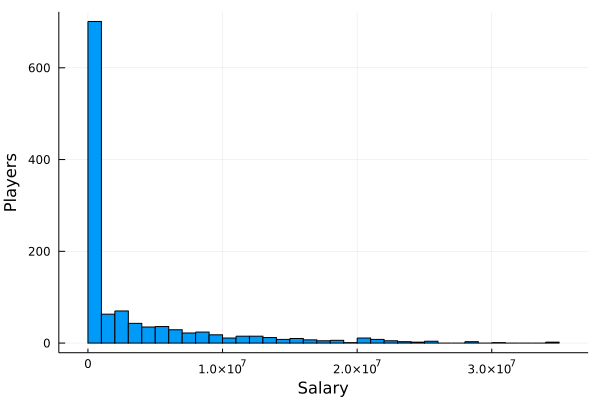

In [7]:
using Plots

salaries = collect(skipmissing(df[!, :Salary]))

histogram(salaries, xlabel="Salary", ylabel="Players", label=:none)